## Postavka zadatka

I ovoga puta su date **dve datoteke** koje sadrže popis **događaja registrovanih na kontrolnim uređajima za pristup** na Matematičkom fakultetu, sada bez anonimizacije i neispravnih unosa. Kraća datoteka sadrži sedmodnevna očitavanja u toku vanrednog stanja u Republici Srbiji usled epidemije koronavirusa, a duža pre toga, što objašnjava razliku u broju događaja uprkos istom vremenskom intervalu. Format je takođe isti – tip *events file*, tabele događaja.

Drugi zadatak podrazumeva **određivanje vremena boravka na fakultetu po svakom korisniku, danu i zgradi**. Ipak, i ovoga puta je neophodno prvo se upoznati sa podacima i opisati ih, posebno zbog toga što nisu izdvojene iste karakteristike kao u prvom zadatku. Predstavljene informacije sasvim su nove.

## Učitavanje podataka

Kako je već napomenuto, podaci su izvezeni u formi **tabele događaja**. Ovaj format započinje **zaglavljem** sa metapodacima koji opisuju tabelu koja sledi, nakon čega se nalazi i sama tabela, u uobičajenom formatu **zapetama razdvojenih vrednosti** (CSV). Prvi red zaglavlja govori o tome da je u pitanju *events file*, generisan programom *PR Master v4.5.12.953*, a drugi sadrži tačno vreme generisanja izveštaja. Slede redovi koji, jedan za drugim, opisuju kolone tabele. Ukupno je 38 atributa, odnosno ID + 37, ali ih je samo devet izdvojeno prilikom generisanja izveštaja. Za rad je zgodno koristiti modul *pandas*.

In [1]:
import pandas as pd

Sledi funkcija za učitavanje podataka. Kako je ručno pročitano iz distribuiranih fajlova, ovoga puta je svaki događaj opisan datumom (*Date*), vremenom (*Time*), kodom (*Event code*) i imenom događaja (*Event name*), imenom pristupne tačke (*Access point name*), zonom (*Zone*), imenom grupe (*Group name*), kao i imenom (*First name*) i prezimenom (*Last name*) korisnika. Jedinstveni identifikator, kao indeksna kolona, izostavljen je, pa se pravi podrazumevani brojčani indeks. Isključeno je prvih 40 redova, koji čine zaglavlje. Datumi su spojeni u jedinstvenu kolonu (*Timestamp*), kao i imena korisnika (*User name*).

In [2]:
kolone = ['Date', 'Time',
          'Event code', 'Event name',
          'Access point name', 'Zone',
          'Group name', 'FN', 'LN']

učitaj = lambda naziv: pd.read_csv(naziv,
                                   skiprows=40,
                                   names=kolone,
                                   parse_dates={'Timestamp': ['Date', 'Time']})\
                         .assign(**{'User name': lambda x: [FN if pd.isnull(FN) else ' '.join((FN, LN))
                                                    for FN, LN in zip(x.FN, x.LN)]})\
                         .drop(columns=['FN', 'LN'])

**Mala** datoteka ima **5.099** unosa od 16. marta 2020. do 22. marta 2020.

In [3]:
mali = učitaj('HumanReadableEventsulaz.20200316-20200323.csv')
#mali

**Velika** datoteka ima **15.460** unosa od 2. marta 2020. do 8. marta 2020.

In [4]:
veliki = učitaj('HumanReadableEventsulaz.20200302-20200308.csv')
#veliki

## Pregled kolona

Nakon opšteg opisa, korisno je utvrditi dodatne osobine atributa. Za to se za početak mogu spojiti svi podaci i nadalje se samo oni koristiti. Ovoga puta postoje preklapanja indeksa, tako da je on za svaki slučaj resetovan. Štaviše, primenjena je radikalnija taktika – indeks je u potpunosti odbačen kao nebitan.

In [5]:
spojeni = pd.concat((veliki, mali))
spojeni.reset_index(drop=True, inplace=True)
#spojeni

Spojeni podaci se i ovoga puta profajliraju pomoću modula **Pandas Profiling**, koji vrši izuzetno detaljnu eksplorativnu analizu. Osim što su detaljni, rezultati analize su predstavljeni u vizuelno vrlo lepoj i interaktivnoj formi. U nastavku su izvojeni najvažniji rezultati.

**Opšti pregled**:
* Svaka četvrta ćelija je nedostajuća (prazna).
* Kako nema indeksa, postoji manji broj dupliranih unosa.
 * Ponovljeni odobren pristup je uglavnom u pitanju.
* Numerički je 1, datumski 1, a kategoričkih 5 atributa.

**Frekvencijska analiza**:
* Tek je tri petine timestampa posebno (*distinct*).
 * Ovo onemogućava posmatranje skupa kao prave vremenske serije.
 * Pravim vremenskim serijama je vreme indeks, dakle jedinstveno.
* Postoji tek desetak različitih tipova događaja.
 * Najčešće je otvaranje i zatvaranje vrata.
* Najviše unosa je u podrazumevanoj (*default*) zoni.
* Nastavnici su najčešća nenedostajuća grupa.
* Najaktivniji pojedinac je Đurđa iz agencije za čišćenje.

**Povezanost atributa**:
* Kod događaja je u jakoj vezi sa njegovim imenom.
 * Kodovi jednoznačno određuju imena.
* Pristupne tačke su u jakoj vezi sa zonama.
 * Pristupna tačka ima fiksno mesto u zgradi.
* Korisnici su u određenoj vezi sa pristupnim tačkama.
 * Isti korisnici često pristupaju istim tačkama.
 * Ovo je već diskutovano u okviru prvog zadatka.

**Nedostajuće vrednosti**:
* Tek svaki deveti unos ima pridruženog korisnika.

In [6]:
from pandas_profiling import ProfileReport

#ProfileReport(spojeni, progress_bar=False)
ProfileReport(spojeni, sensitive=True, progress_bar=False)

## Funkcionalne zavisnosti

Još jednom, zanimljivo je proveriti pretpostavljene **funkcionalne zavisnosti** kao test **integriteta podataka**. Očekivano bi bilo:
* {Event code} $\rightarrow$ {Event name},
* {Access point name} $\rightarrow$ {Zone},
* {User name} $\rightarrow$ {Group name}.

Ukoliko bi se to ispostavilo kao istinito, bilo bi dovoljno duplo manje karakteristika, a da se pritom u potpunosti zadrži znanje o skupu, bez suštinskog gubitka informacija. I dalje bi bilo poznato ko je tačno, kad i šta uradio. Gube se jedino dodatne informacije koje nisu toliko važne za razumevanje događaja.

U nastavku je funkcija koja ispituje pretpostavljene zavisnosti i obaveštava ukoliko su narušene. Pritom čuva **mapu** koja prvi argument preslikava u drugi, indeks prvog događaja čiji su glavni akteri, kao i broj događaja pridruženih prvom argumentu. Metoda je, međutim, ne vraća, pošto je mapa glomazna za prikaz, ali bi se lako mogla doraditi npr. tako da je sortira po ključevima i sačuva u *JSON* formatu ili u formi nove nezavisne tabele relacija.

In [7]:
jednaki = lambda x, y: x == y or pd.isnull(x) and pd.isnull(y)

def zavisnost(df, col1, col2):
    mapa = {}
    ok = True
    
    for ind, unos in df.iterrows():
        key = unos[col1]
        val = unos[col2]
        
        if key in mapa:
            mapa[key]['broj'] += 1
            
            if not jednaki(val, mapa[key]['ime']):
                ok = False
                
                print('Promena!')
                print(f'Prethodno ({mapa[key]["ind"]}): {key} \u2192 {mapa[key]["ime"]}')
                print(f'Sada ({ind}): {key} \u2192 {val}')
                
                mapa[key]['ime'] = val
                mapa[key]['ind'] = ind
        else:
            mapa[key] = {'ime': val, 'ind': ind, 'broj': 1}
    
    if ok:
        print(f'Sve implikacije, njih {len(mapa)}, uklapaju se!')
    else:
        print('Ukupan broj implikacija:', len(mapa))

Bez problema je ispunjen uslov da kod događaja neposredno određuje ime događaja.

In [8]:
zavisnost(spojeni, 'Event code', 'Event name')

Sve implikacije, njih 17, uklapaju se!


U nastavku su izlistani svi mogući događaji. Pojedini detalji se mogu naći u [priručniku](https://www.roger.pl/en/component/docman/doc_download/1605-access-controllers-prxx2-functional-description.html) za tip uređaja koji se koristi na Matematičkom fakultetu, u izradi poljske sigurnosne firme Roger. Kada su korisnici u pitanju, moguće je dobiti pristup (001) ili biti odbijen (002). Isključivo je **prvi tip događaja od interesa**.

In [9]:
događaji = spojeni['Event name'].unique()
print('\n'.join(sorted(događaji)))

[001]: Access granted
[002]: Access denied
[003]: PREALARM
[004]: DOOR AJAR
[005]: FORCED ENTRY
[008]: Controller restart
[035]: Door set to Unlocked mode
[044]: Unknown card
[045]: Unknown PIN
[501]: Door open
[502]: Door closed
[505]: Communication with term.ID1 returned
[506]: Communication with term.ID1 lost
[517]: Low Battery alarm ON
[518]: Low Battery alarm OFF
[519]: AC Lost alarm ON
[521]: Battery failure


Nema problema ni kod uslova da je pristupna tačka u fiksiranoj zoni.

In [10]:
zavisnost(spojeni, 'Access point name', 'Zone')

Sve implikacije, njih 72, uklapaju se!


Kod pretpostavljenog uslova da je korisnik u fiksiranoj grupi javljaju se **sitne razlike**. Naime, dva korisnika prešla su u novu grupu. Međutim, kako je u pitanju grupa koja apostrofira **vanrednost**, a prelazak se dogodio u ponedeljak, 16. marta 2020, baš dan nakon proglašenja vanrednog stanja u Republici Srbiji usled epidemije koronavirusa, biće da je u pitanju namenska grupa za korisnike koji su u prvim danima vanrednog stanja rukovodili situacijom na fakultetu.

In [11]:
zavisnost(spojeni, 'User name', 'Group name')

Promena!
Prethodno (1399): Slavi�a Milisavljevic → Slavisa
Sada (16320): Slavi�a Milisavljevic → A Ulaz Vanredno
Promena!
Prethodno (828): Radivoj Protic → Akvarijum
Sada (16468): Radivoj Protic → A Ulaz Vanredno
Ukupan broj implikacija: 147


Inače, postoji 146 korisnika (+ NaN) i oni će biti proučavani u nastavku.

In [12]:
#spojeni['User name'].unique()

## Tok vremena

Za razliku od prvog zadatka, ovde **vreme** ne igra krucijalnu ulogu, pa nije jedino bitno, ali je i dalje vrlo značajno. U distribuiranim datotekama je ono dato kroz dve kolone, odvojeno kao datum ili vreme, ali su one, jednostavnosti radi, spojene u jednu koja predstavlja **vremensku oznaku** (*timestamp*).

In [13]:
vreme = spojeni.Timestamp
vreme

0       2020-03-02 00:32:20
1       2020-03-02 00:32:50
2       2020-03-02 00:46:30
3       2020-03-02 00:51:20
4       2020-03-02 00:54:50
                ...        
20554   2020-03-22 23:55:30
20555   2020-03-22 23:56:10
20556   2020-03-22 23:57:20
20557   2020-03-22 23:58:40
20558   2020-03-22 23:58:40
Name: Timestamp, Length: 20559, dtype: datetime64[ns]

Za početak, nije loše utvrditi da li je skup sortiran (monoton) po vremenu. Jeste, i to rastuće, dakle to je okej.

In [14]:
vreme.is_monotonic_increasing

True

Dobar uvid u **vremensku seriju** daje njen **histogram**, koji posmatra broj događaja kao funkciju vremena. Oduzeto mu je dvanaest sati, kako bi oznake bile baš u podne, a ne u ponoć, što može da izgleda zbunjujuće na slici.

In [15]:
from datetime import timedelta

razlika = timedelta(hours=12)

Svake noći, a posebno u podacima iz male datoteke, primetan je veliki broj naizgled besmislenih događaja u Jagićevoj. Naime, uporno se po celu noć očitava nekakva nepoznata kartica. Iako nije deo zadatka, nemoguće je to ne uočiti. Da li tamošnji su uređaji pokvareni ili podaci ipak nisu ispravni?

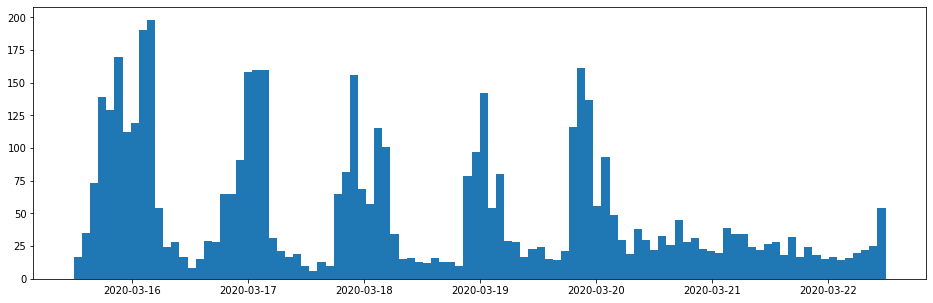

In [16]:
_ = (mali.Timestamp - razlika).hist(bins=100, grid=False, xlabelsize=10, ylabelsize=10, figsize=(16, 5))

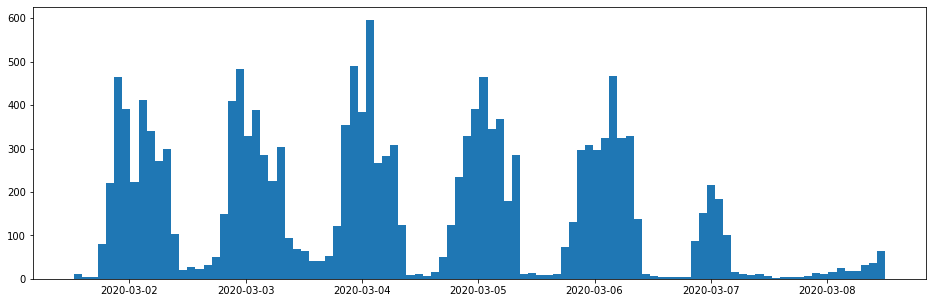

In [17]:
_ = (veliki.Timestamp - razlika).hist(bins=100, grid=False, xlabelsize=10, ylabelsize=10, figsize=(16, 5))

## Filtriranje podataka

Nakon uvodnih razmatranja, valja se podsetiti zadatka. Ideja je emulirati **sistem za praćenje vremena i prisustva** (*time and attendance*, T&A). Za te potrebe, isključivo su važni događaji dobijenog pristupa, odnosno koda **1** i imena **[001]: Access granted** i samo oni se u nastavku izvajaju. Ovime je skup već prilično sužen, sa polaznih preko dvadeset hiljada događaja na tek nešto više od tri hiljade. Sada i dva atributa imaju samo jednu različitu vrednost.

In [18]:
skup = spojeni[spojeni['Event code'] == 1]
#skup

U nastavku se radi sa kopijom, pa se to posebno naglašava modulu *pandas*, kako se ne bi ispisivala nepotrebna upozorenja.

In [19]:
pd.set_option('mode.chained_assignment', None)

Dodatno, nema svrhe zadržati ni one odobrene pristupe čiji **pokretač (korisnik) nije zabeležen**, jer se na osnovu njih ništa ne može zaključiti po pitanju prisustva. Kada se izbace oni, kao i kolone koje ponavljaju kod i ime događaja, prethodni skup dimenzija 3368 × 7 svodi se na novi 2432 × 5.

In [20]:
skup = skup[~skup['User name'].isna()]
skup.drop(columns=['Event code', 'Event name'], inplace=True)
#skup

Na kraju, neophodno je razdvojiti dešavanja na Trgu i u Jagićevoj, pa se za te potrebe uvodi indikator umesto ostalih atributa.

In [21]:
skup['Jag'] = skup.Zone.map(lambda x: x.startswith('Jag'))
skup.drop(columns=['Access point name', 'Zone', 'Group name'], inplace=True)
#skup

Ovo je pročistilo prethodno uočene nepravilnosti i histogrami sada izgledaju mnogo smislenije, bez celonoćnih aktivnosti. Takođe, broj dana za razmatranje je smanjen za tri, sa četrnaest na jedanaest. Naime, nije bilo važnih aktivnosti u nedelju, 8. marta, kao ni oba dana vikenda za vreme vanrednog stanja.

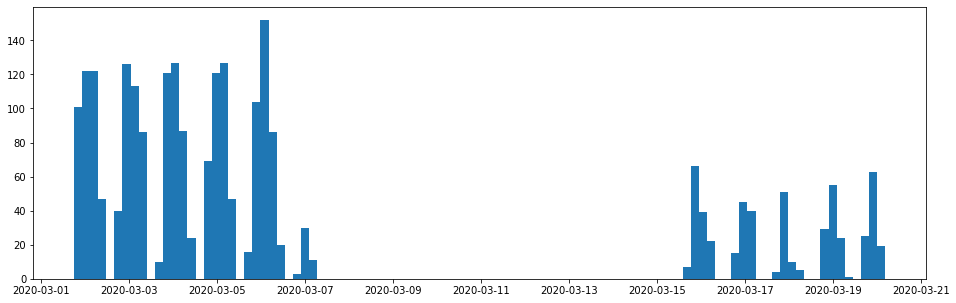

In [22]:
_ = (skup.Timestamp - razlika).hist(bins=100, grid=False, xlabelsize=10, ylabelsize=10, figsize=(16, 5))

## Procena prisustva

U nastavku je implementiran jednostavan algoritam za **procenu** vremena prisustva u odnosnu na korisnika, dan i zgradu fakulteta. Rezultat je dat tabelarno, sa trima pomenutim kolonama kao ključnim, a formiran je poštujući sledeća pravila, odnosno tako da ispunjava sledeće kriterijume:
 * Ukoliko korisnik nije očitao karticu ceo dan, ne nalazi se u rezultujućoj tabeli.
 * U suprotnom, vreme se ceni kao razlika između najranijeg i najkasnijeg očitavanja.
  * Specijalan slučaj: samo jednom očitana kartica rezultuje procenjenim vremenom nula.
 * Ukoliko je korisnik u toku dana posetio obe zgrade, posebno se pazi na intervale.
  * U skupu je neko npr. pre podne bio na Trgu, a popodne u Jagićevoj.

Rezultujuća tabela ima 443 reda, koji osim datuma, korisnika i zgrade čuvaju podatke o prvoj i poslednjoj aktivnosti, kao i razlici – procenjenom prisustvu.

In [23]:
prisustvo = []

for datum, df in skup.groupby(lambda ind: skup.loc[ind].Timestamp.date()):
    for (korisnik, zgrada), df in df.groupby(['User name', 'Jag']):
        polazno = df.Timestamp.iloc[0]
        zavrsno = df.Timestamp.iloc[-1]
        
        prisustvo.append([str(datum), korisnik,
                          'Jagić' if zgrada else 'Trg',
                          str(polazno)[11:],
                          str(zavrsno)[11:],
                          str(zavrsno - polazno)[7:]])

prisustvo = pd.DataFrame(prisustvo, columns=['Date', 'User name', 'Location',
                                             'First activity', 'Last activity', 'T&A'])

prisustvo.sort_values('T&A', ascending=False, inplace=True)

prisustvo.to_csv('MATF_T&A.csv', encoding='utf-8-sig', index=False)

#prisustvo

Dobijeni podaci se **profajliraju** već pomenutim modulom za eksplorativnu analizu, kako bi dodatno mogli da se razmotre. Ne uočavaju se, međutim, neke posebne zanimljivosti niti novosti, osim možda visokog udela nultih procena, kao i toga da je znatno više aktivnosti na Trgu nego u Jagićevoj.

In [24]:
#ProfileReport(prisustvo, progress_bar=False)
ProfileReport(prisustvo, sensitive=True, progress_bar=False)

## Vizuelizacija

Po želji, moguće je lepo i **slikovito** prikazati nečije prisustvo na nivou dana. To će biti urađeno na primeru Miodraga Radojevića, koji je 2. marta proveo izvesno vreme na obe lokacije – pre podne je bio u Jagićevoj, a uveče na Trgu, pri čemu su obe procene dobre, a ne beskorisne nulte.

In [25]:
mika = prisustvo[prisustvo['User name'] == 'Miodrag Radojevic Demonstrator 7']
mika['User name'] = 'Miodrag Radojević'
mika

,Date,User name,Location,First activity,Last activity,T&A
39,2020-03-02,Miodrag Radojević,Jagić,10:15:10,13:02:20,02:47:10
263,2020-03-05,Miodrag Radojević,Trg,13:51:50,16:06:00,02:14:10
38,2020-03-02,Miodrag Radojević,Trg,18:54:20,21:05:00,02:10:40
178,2020-03-04,Miodrag Radojević,Trg,15:20:30,15:20:30,00:00:00


Definisana je funkcija za ilustraciju aktivnosti korisnika po datumu. Prikazan je i lepo obojen ceo dan, sa legendom aktivnosti.

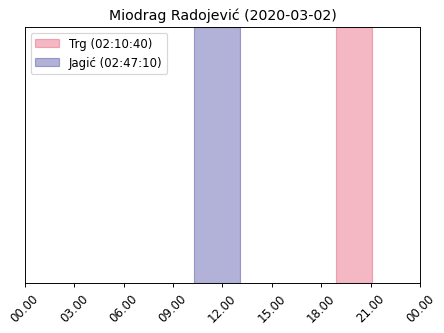

In [26]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import HourLocator, DateFormatter
plt.rcParams['figure.dpi'] = 85

ymd = lambda datum: datetime(*map(int, datum.split('-'))) # fromisoformat

vreme = lambda niska, datum: datetime.strptime(niska, '%H:%M:%S')\
        .replace(year=datum.year, month=datum.month, day=datum.day)

def ilustruj(skup, datum, korisnik):
    skup = skup[(skup.Date == datum) & (skup['User name'] == korisnik)]
    if skup.empty: return
    
    ponoć = ymd(datum)
    kraj = ponoć + timedelta(days=1)
    
    plt.xlim(ponoć, kraj)
    
    ax = plt.gca()
    plt.setp(ax.xaxis.get_majorticklabels(), 'rotation', 45)
    
    ax.xaxis.set_major_locator(HourLocator(interval=3))
    ax.xaxis.set_major_formatter(DateFormatter('%H.%M'))
    
    ax.tick_params(axis='y', left=False, labelleft=False)
    
    trg = skup[skup.Location == 'Trg']
    if not trg.empty:
        trg = trg.iloc[0]
        ax.axvspan(vreme(trg['First activity'], ponoć),
                   vreme(trg['Last activity'], ponoć),
                   label=f'Trg ({trg["T&A"]})',
                   color='crimson', alpha=0.3)
    
    jag = skup[skup.Location == 'Jagić']
    if not jag.empty:
        jag = jag.iloc[0]
        ax.axvspan(vreme(jag['First activity'], ponoć),
                   vreme(jag['Last activity'], ponoć),
                   label=f'Jagić ({jag["T&A"]})',
                   color='navy', alpha=0.3)
    
    plt.title(f'{korisnik} ({datum})')
    plt.legend()

ilustruj(mika, '2020-03-02', 'Miodrag Radojević')

## Dodatne ideje

Prethodno izneti pristup, iako jedini logičan, ima **nekoliko problema**. Glavni je taj da je dobar deo procena beskorisno. Naime, svaka peta do četvrta je nulta, odnosno korisnik je samo jednom očitao karticu. Ovo jeste dokaz da je upitni korisnik taj dan bio na fakultetu, ali ne govori ništa značajno o provedenom vremenu. Pokušaj popravke mogao bi biti praćenje **otvaranja i zatvaranja vrata**, koje bi potencijalno poboljšalo procenu boravka u prostoriji i bez očitavanja kartice. Ovo bi, ipak, bilo znatno kompleksnije za implementaciju nego što bi koristilo, jer se vrata mogu proizvoljno otvarati i zatvarati iznutra, a često i spolja.

In [27]:
print('Broj nultih procena:', sum(prisustvo['T&A'] == '00:00:00'))

Broj nultih procena: 98


S druge strane, postoje i **suštinski** problemi. Primera radi, samo je jedan ulaz u zgradu na Trgu zaštićen, dok se na ostale (hemijski, zadnji iz Simine...) može ući **bez otkucavanja identifikacione kartice**, kako već i studenti i ostali posetioci ulaze. Kada se to spoji sa mogućnošću da neke učionice budu po ceo dan otljučane i otvorene, kao što je 706, bez problema je moguće biti na fakultetu, a da to sistem za kontrolu pristupa jednostavno nema načina kako da uoči.

Moguće je i suprotno – ući na zaštićena vrata i ubrzo izaći na nezaštićena, a onda se kasnije vratiti na nezaštićena i izaći na zaštićena. Time se može stvoriti iluzija celodnevnog prisustva, iako je stvarnost drastično različita. Naravno, ovo se može dogoditi kako namerno, tako i nenamerno – neko ima nastavu i pre i posle podne, između čega ide kući ili negde drugde da pauzira. Pritom ne postoji način da se tačno zna kad je napustio fakultet prvi put, a kad se opet vratio.

## Zaključak

Prilikom analize skupa, razmotreni su **odnosi karakteristika** unutar njega, kao i **integritet podataka (funkcionalne zavisnosti)**. Samo je jedan tip događaja – **dobijeni pristup** – označen kao važan za rešavanje problema procene **vremena i prisustva** (T&A). Podaci su **filtrirani** po toj vrednosti atributa, čime je značajno smanjena dimenzionalnost skupa. Sve kolone sem vremenske oznake i punog imena korisnika su odbačene, mada je dodat indikator lokacije.

Ovako dobijeni prečišćeni skup poslužio je za procenu prisustva – transformisan je u novu tabelu, koja umesto vremenske oznake čuva samo datum, ali dodatno čuva i podatke o prvoj i poslednjoj aktivnosti tog datuma, kao i procenjenom vremenu prisustva (razlici). Rezultujuća tabela može poslužiti za **upite** prema datumu, korisniku, lokaciji, kombinaciji ta tri, pa čak i prema aktivnostima – ko je najduže prisutan, ko najranije dolazi, ko najkasnije odlazi... Prikazan je jedan način za **vizuelizaciju** individualnog rezultata jednog takvog upita prema korisniku i datumu, na primeru korisnika koji je istog dana posetio obe zgrade.

Iako jedini logičan, ovakav pristup je, ipak, po mnogo čemu **nedorečen i problematičan**, što je detaljnije prodiskutovano u prethodnom podnaslovu. Sve u svemu, T&A ima najviše smisla pratiti u firmama sa strogom kontrolom pristupa, a manje u otvorenim institucijama kao što su državne obrazovne ustanove. Ovo se pogotovu odnosi na zgradu Matematičkog fakulteta na Studentskom trgu, dok je u Jagićevoj više prostora za analizu, mada znatno manje podataka.